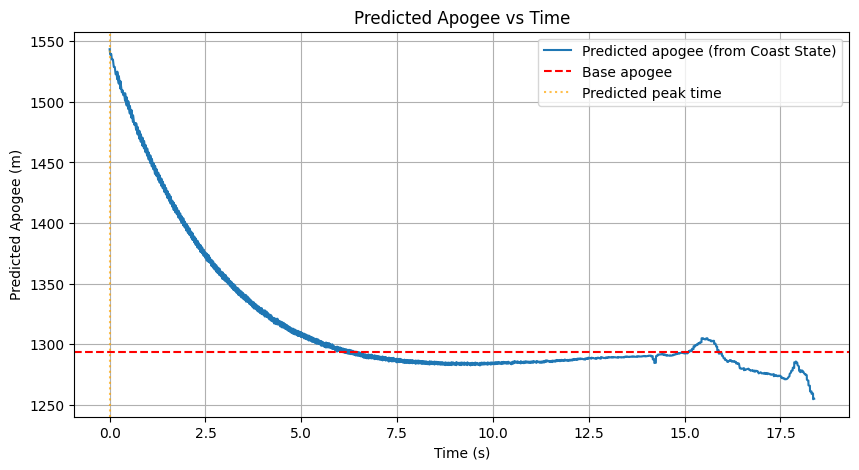

In [8]:
#Method 1: Simplistic 1-D analytical approach with no drag
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv(
    "pelicanator_launch_4.csv",
    dtype={
        "timestamp": "float64",
        "current_altitude": "float64",
        "vertical_velocity": "float64",
        "state_letter": "string"
    },
    low_memory=False
)

# Keep only coast phase data (state_letter == 'C')
df_c = df[df["state_letter"] == "C"]

# Keep only valid rows
df_clean = df_c[["timestamp", "current_altitude", "vertical_velocity", "vertical_acceleration"]].dropna()

# Convert timestamps to seconds from start
t_ns = df_clean["timestamp"].to_numpy()
t = (t_ns - t_ns[0]) / 1e9



# Extract altitude and velocity
alt = df_clean["current_altitude"].to_numpy()
vel = df_clean["vertical_velocity"].to_numpy()

# Constants
g = 9.81
base_apogee = max(alt)  # meters

# Predict apogee using physics model
predicted_apogee = alt + vel**2 / (2 * g)

# Compute final predicted apogee and deviation from base apogee
idx_pred = np.argmax(predicted_apogee)
predicted_peak = predicted_apogee[idx_pred]
time_pred = t[idx_pred]

# Plot predicted apogee progression
plt.figure(figsize=(10,5))
plt.plot(t, predicted_apogee, label="Predicted apogee (from Coast State)")
plt.axhline(base_apogee, color="red", linestyle="--", label="Base apogee")
plt.axvline(time_pred, color="orange", linestyle=":", alpha=0.7, label="Predicted peak time")
plt.xlabel("Time (s)")
plt.ylabel("Predicted Apogee (m)")
plt.title("Predicted Apogee vs Time")
plt.legend()
plt.grid(True)
plt.show()



Estimated drag constant K (median) ≈ 2.523348e-04


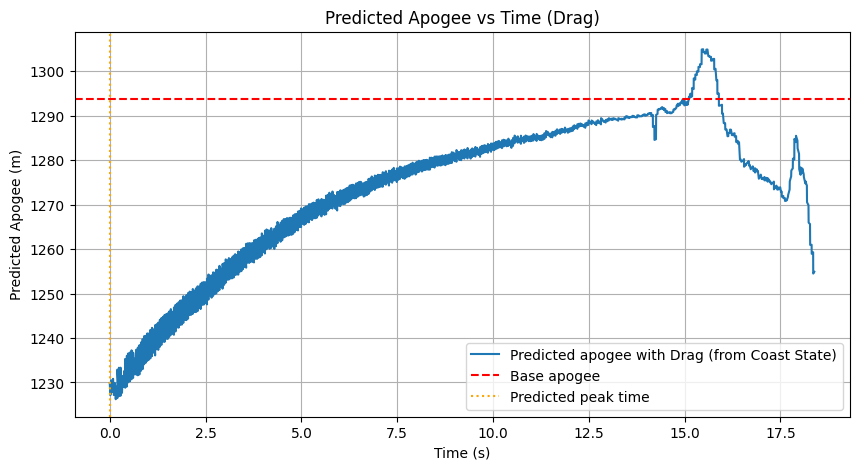

In [9]:
#Method 2: accounting for drag analytical solution
acc_drag = df_clean["vertical_acceleration"].to_numpy()
K_values = -acc_drag / (vel**2)
K_median = np.median(K_values)
print(f"Estimated drag constant K (median) ≈ {K_median:.6e}")

predicted_apogee_drag = alt + (1 / (2 * K_median)) * np.log(1 + (K_median * vel**2) / g)

plt.figure(figsize=(10,5))
plt.plot(t, predicted_apogee_drag, label="Predicted apogee with Drag (from Coast State)")
plt.axhline(base_apogee, color="red", linestyle="--", label="Base apogee ")
plt.axvline(time_pred, color="orange", linestyle=":", label="Predicted peak time")
plt.xlabel("Time (s)")
plt.ylabel("Predicted Apogee (m)")
plt.title("Predicted Apogee vs Time (Drag)")
plt.legend()
plt.grid(True)
plt.show()

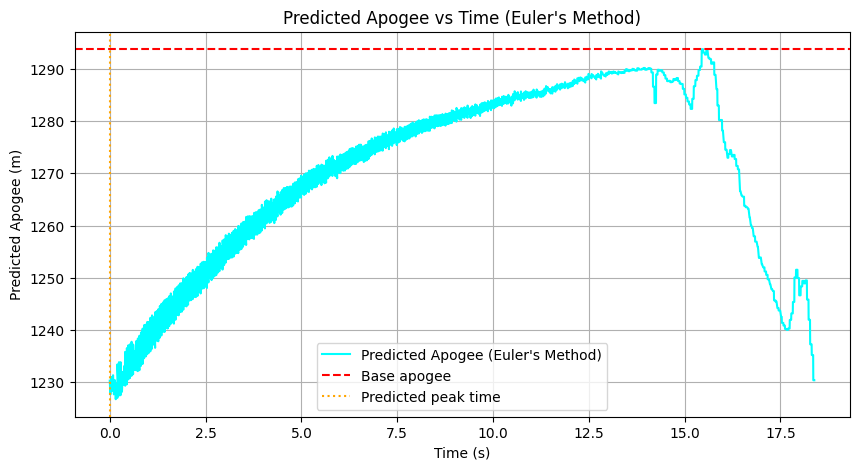

In [10]:
from scipy.integrate import solve_ivp

def simulate_apogee_euler(h_start, v_start, K, g, dt=0.01):

    current_altitude = h_start
    current_velocity = v_start

    max_loops = 50000

    for _ in range(max_loops):

        if current_velocity <= 0:
            return current_altitude
        # dh/dt is velocity
        d_altitude_dt = current_velocity

        # dv/dt is a_net (gravity + drag)
        d_velocity_dt = -g - K * (current_velocity**2)

        # h_next = h_current + (dh/dt) * dt
        current_altitude = current_altitude + d_altitude_dt * dt

        # v_next = v_current + (dv/dt) * dt
        current_velocity = current_velocity + d_velocity_dt * dt

    return current_altitude

# List to contain all apogee predictions
apogee_pred_euler = []

# Loop over every entry in our coast-up data
for i in range(len(alt)):
    predicted_apogee = simulate_apogee_euler(alt[i], vel[i], K_median, g, dt=0.01)
    apogee_pred_euler.append(predicted_apogee)


plt.figure(figsize=(10,5))

plt.plot(t, apogee_pred_euler, label="Predicted Apogee (Euler's Method)", color="cyan")
plt.axhline(base_apogee, color="red", linestyle="--", label="Base apogee")
plt.axvline(time_pred, color="orange", linestyle=":", label="Predicted peak time")
plt.xlabel("Time (s)")
plt.ylabel("Predicted Apogee (m)")
plt.title("Predicted Apogee vs Time (Euler's Method)")
plt.legend()
plt.grid(True)
plt.show()
